In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True) #ON by default

In [5]:
# Using GPU
CUDA = torch.cuda.is_available()
print("CUDA is available:",CUDA)

device = torch.device("cuda" if CUDA else "cpu")
print(device)

print(torch.__version__)
print(torchvision.__version__)

CUDA is available: True
cuda
1.8.1+cu101
0.9.1+cu101


In [6]:
# Function to get number of correct classifications
def get_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [7]:
# Train Dataset for MNIST
train_set = torchvision.datasets.MNIST(
    root='./data/'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
                                    transforms.ToTensor()
    ]) 
)

# Test data set for MNIST
test_set = torchvision.datasets.MNIST(
    root='./data/'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
                                    transforms.ToTensor()
    ]) 
)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
# Model for MNIST Digit classification and ADDER classification
# Input1 : 28x28 digit image to cov layer 1
# Input 2 : One-hot encoding of digit 0-9
# Output 1 : MNIST image digit classification
# Output 2 : Retrun SUM of MINIT Digit and Input2 digit

class Network(nn.Module):
  def __init__(self):
    super().__init__()
    # These act as attributes
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=(12*4*4) + 10, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out1 = nn.Linear(in_features=60, out_features=10)
    self.out2 = nn.Linear(in_features=60, out_features=19)

  def forward(self, t, d):

    #(1) input layer : not necessary to write- just for understanding purpose
    t = t

    #(2) hidden conv1 layer
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    #(3) hidden conv2 layer
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    #(4) hidden fc1 linear layer
    t = t.reshape(-1, 12*4*4)
    # Concatenating one hot encoding of input2 digit to FC layer
    t = torch.cat((t, d), dim=1) 
    t = self.fc1(t)
    t = F.relu(t)

    #(5) hidden fc2 linear layer
    t = self.fc2(t)
    t = F.relu(t)

    #(6) output linear layer
    t1 = self.out1(t)
    t2 = self.out2(t)

    return t1, t2

In [9]:
# Can write more on Decision on these params
num_epoch = 50 # number of times to iterate on complete dataset
batch_size = 100 # subset or records to fetch at once
learning_rate = 0.005 # Can be played around with for better

In [10]:
network = Network().to(device)
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=202, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out1): Linear(in_features=60, out_features=10, bias=True)
  (out2): Linear(in_features=60, out_features=19, bias=True)
)


In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size) # for training iter
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size) # for testing post each epoch
optimiser = optim.Adam(network.parameters(), lr=learning_rate)

# metrics to capture as we train for multiple epochs : understand where are losses more, when it becomes flat, when to stop/ needs fixes
train_loss = []
train_lossMNIST = []
train_lossADDER = []

train_accMNIST = []
train_accADDER =[]

test_accMNIST = []
test_accADDER = []

for epoch in range(num_epoch):

  lossMNIST = 0
  lossADDER = 0

  accMNIST = 0
  accADDER = 0
  
  for batch in train_loader:
    images, labels = batch 
    images = images.to(device)
    labels = labels.to(device)

    # Random digits generated
    digits = torch.randint(0, 10, (batch_size,)) # batch_size rand ints
    digits_one = F.one_hot(digits, num_classes=10) # one hot encoding
    digits_one = digits_one.to(device)
    digits = digits.to(device)
    #digits = digits.unsqueeze(dim=1)

    preds1, preds2 = network(images, digits_one) # Pass Batch
    loss1 = F.cross_entropy(preds1, labels) # Calculate Loss
    loss2 = F.cross_entropy(preds2, digits + labels) # Calculate Loss

    loss = loss1 + loss2

    optimiser.zero_grad()
    loss.backward() #Calculating Gradients
    optimiser.step() # Updating the weights

    lossMNIST += loss1.item()
    lossADDER += loss2.item()

    accMNIST += get_correct(preds1, labels)
    accADDER += get_correct(preds2, digits+labels)

  train_loss.append(lossMNIST + lossADDER)
  train_lossMNIST.append(lossMNIST)
  train_lossADDER.append(lossADDER)

  train_accMNIST.append((accMNIST/len(train_set))*100)
  train_accADDER.append((accADDER/len(train_set))*100)
  
  print('epoch:', epoch, 'Train: Loss MNIST', lossMNIST, '; Loss Adder: ', lossADDER)

  accMNIST = 0
  accADDER = 0
  # Predicting on test data -----------
  for batch in test_loader:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    # Random digits generated
    digits = torch.randint(0, 10, (batch_size,)) # batch_size rand ints
    digits_one = F.one_hot(digits, num_classes=10) # one hot encoding 0-9 : 10 different values : *could improvised here*
    digits_one = digits_one.to(device)
    digits = digits.to(device)

    # Do predictions
    preds1, preds2 = network(images, digits_one)

    accMNIST += get_correct(preds1, labels)
    accADDER += get_correct(preds2, digits+labels)

  test_accMNIST.append((accMNIST/len(test_set))*100)
  test_accADDER.append((accADDER/len(test_set))*100)

  print('epoch:', epoch, 'test: Accuracy MNIST', accMNIST/len(test_set), '; Accuracy Adder: ', accADDER/len(test_set) )

epoch: 0 Train: Loss MNIST 177.6698213312775 ; Loss Adder:  931.55777554214
epoch: 0 test: Accuracy MNIST 0.9568 ; Accuracy Adder:  0.9175
epoch: 1 Train: Loss MNIST 60.07009452988859 ; Loss Adder:  108.7903512949124
epoch: 1 test: Accuracy MNIST 0.9804 ; Accuracy Adder:  0.9694
epoch: 2 Train: Loss MNIST 44.41233837022446 ; Loss Adder:  61.52178240381181
epoch: 2 test: Accuracy MNIST 0.9818 ; Accuracy Adder:  0.9781
epoch: 3 Train: Loss MNIST 36.9115229168674 ; Loss Adder:  50.2233901633881
epoch: 3 test: Accuracy MNIST 0.9852 ; Accuracy Adder:  0.9817
epoch: 4 Train: Loss MNIST 33.387544514931506 ; Loss Adder:  45.47076621535234
epoch: 4 test: Accuracy MNIST 0.9794 ; Accuracy Adder:  0.9784
epoch: 5 Train: Loss MNIST 30.7285102558817 ; Loss Adder:  40.975391787011176
epoch: 5 test: Accuracy MNIST 0.9813 ; Accuracy Adder:  0.9796
epoch: 6 Train: Loss MNIST 28.802567418970284 ; Loss Adder:  38.524760568514466
epoch: 6 test: Accuracy MNIST 0.982 ; Accuracy Adder:  0.9795
epoch: 7 Train:

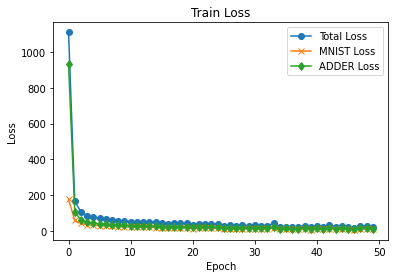

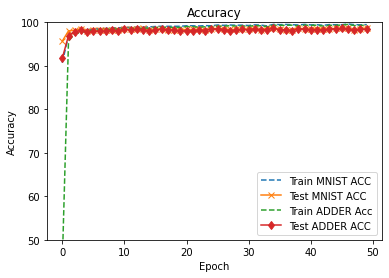

In [12]:

# Plotting metrics to see how model as learned and loss decreased
import matplotlib.pyplot as plt

plt.plot(range(epoch+1), train_loss, marker='o')
plt.plot(range(epoch+1), train_lossMNIST, marker = 'x')
plt.plot(range(epoch+1), train_lossADDER, marker = 'd')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Total Loss", "MNIST Loss", "ADDER Loss"])
plt.title("Train Loss")
#plt.ylim([0,100])
plt.show()

plt.plot(range(epoch+1), train_accMNIST, linestyle='dashed')
plt.plot(range(epoch+1), test_accMNIST, marker = 'x')
plt.plot(range(epoch+1), train_accADDER, linestyle='dashed')
plt.plot(range(epoch+1), test_accADDER, marker = 'd')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train MNIST ACC", "Test MNIST ACC", "Train ADDER Acc", "Test ADDER ACC"])
plt.title("Accuracy")
plt.ylim([50,100])
plt.show()

#Functions to plot Classifications and show examples results
#There could be 4 combinations -

Correct Image Class & Correct Addition

Correct Image Class & Wrong Addition

Wrong Image Class & Correct Addition

Wrong Image Class & Wrong Addition

In [13]:
def correct_idx(a_c, p_c):
  correct_idx = p_c.eq(a_c).nonzero(as_tuple=True)
  return correct_idx[0]
  # print(correct_idx)
def wrong_idx(a_c, p_c):
  wrong_idx = p_c.ne(a_c).nonzero(as_tuple=True)
  return wrong_idx[0]

def get_outputs(images,actual_class,pred_class,actual_sum,pred_sum,digits,class_id,sum_id):
  imgs = images[class_id][sum_id]
  lbls = actual_class[class_id][sum_id]
  predict_class = pred_class[class_id][sum_id]
  sums = actual_sum[class_id][sum_id]
  predict_sums = pred_sum[class_id][sum_id]
  rn = digits[class_id][sum_id]
  return imgs,lbls,predict_class,sums,predict_sums,rn

def show_results(imgs,lbls,predict_class,sums,predict_sums,rn,bgcolor = "white", tcolor = "black"):
  fig = plt.figure(figsize=(14,14), facecolor = bgcolor)
  img_count = len(imgs)
  if img_count == 0:
    print("ALl the additions for this batch was correct")
  elif img_count >= 1:
    if img_count > 6:
      img_count = 6
    for i in range(img_count):
      plt.subplot(1,img_count,i+1)
      # plt.tight_layout()
      plt.imshow(imgs[i][0].to("cpu"), cmap='gray', interpolation='none')
      plt.title("Actual {} + {} = {} \n Predicted {} + {} = {}".format(lbls[i],rn[i],sums[i],
                                                              predict_class[i],rn[i],predict_sums[i]),
                color = tcolor)
      plt.xticks([])
      plt.yticks([])
    plt.show()

Results for Correct Image class and Correct additions


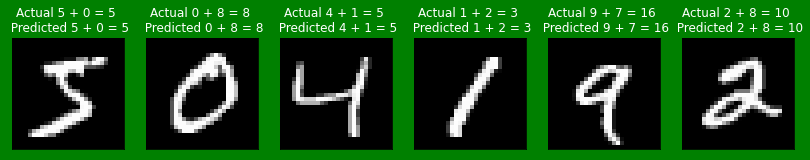

Results for Correct Image class and Wrong Additions


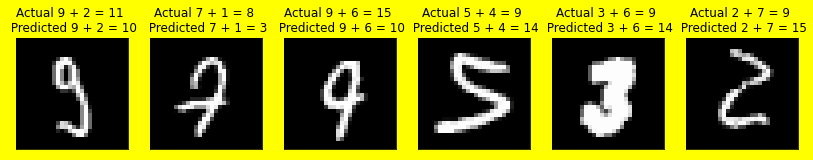

Results for Wrong Image class and Correct additions


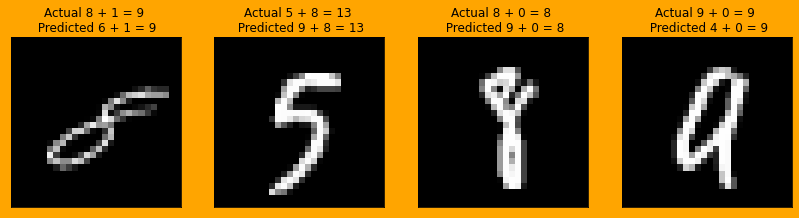

Results for Wrong Image class and Wrong Additions


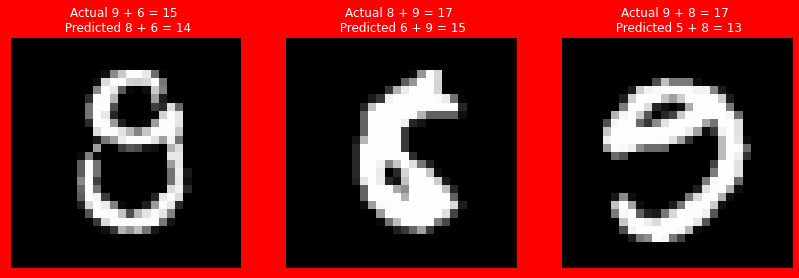

In [14]:
# Plotting the results correctly classified and wrongly classifed
# for images, labels in train_loader: 

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 2000)
j=1

class_all_correct_idx = torch.IntTensor()
sum_all_correct_idx = torch.IntTensor()

for images, labels in train_loader:
  images = images.to(device)
  labels = labels.to(device)

  # Random digits generated
  digits = torch.randint(0, 10, (2000,)) # 100 rand ints
  digits_one = F.one_hot(digits, num_classes=10) # one hot encoding
  digits_one = digits_one.to(device)
  digits = digits.to(device)

  # Run the model   
  preds_class_prob, preds_sum_prob = network(images, digits_one) # Pass Batch
  
  pred_class = preds_class_prob.argmax(dim=1)
  pred_sum = preds_sum_prob.argmax(dim=1)
  actual_class = labels
  actual_sum = labels+digits

  # Get ID of the correct classification
  class_correct_idx = correct_idx(actual_class, pred_class)

  #Get IDs for correct additions
  sum_correct_idx = correct_idx(actual_sum[class_correct_idx], pred_sum[class_correct_idx])
  imgs,lbls,predict_class,sums,predict_sums,rn = get_outputs(images,actual_class,pred_class,actual_sum,pred_sum,digits,class_correct_idx,sum_correct_idx)
  print("Results for Correct Image class and Correct additions")
  show_results(imgs,lbls,predict_class,sums,predict_sums,rn,"green",tcolor = "white")

  #Get IDs for wrong additions
  sum_wrong_idx = wrong_idx(actual_sum[class_correct_idx], pred_sum[class_correct_idx])
  imgs,lbls,predict_class,sums,predict_sums,rn = get_outputs(images,actual_class,pred_class,actual_sum,pred_sum,digits,class_correct_idx,sum_wrong_idx)
  print("Results for Correct Image class and Wrong Additions")
  show_results(imgs,lbls,predict_class,sums,predict_sums,rn,"yellow")
  # Get ID of the correct classification
  class_wrong_idx = wrong_idx(actual_class, pred_class)

  #Get IDs for correct additions
  sum_correct_idx = correct_idx(actual_sum[class_wrong_idx], pred_sum[class_wrong_idx])
  imgs,lbls,predict_class,sums,predict_sums,rn = get_outputs(images,actual_class,pred_class,actual_sum,pred_sum,digits,class_wrong_idx,sum_correct_idx)
  print("Results for Wrong Image class and Correct additions")
  show_results(imgs,lbls,predict_class,sums,predict_sums,rn,"orange")

  #Get IDs for wrong additions
  sum_wrong_idx = wrong_idx(actual_sum[class_wrong_idx], pred_sum[class_wrong_idx])
  imgs,lbls,predict_class,sums,predict_sums,rn = get_outputs(images,actual_class,pred_class,actual_sum,pred_sum,digits,class_wrong_idx,sum_wrong_idx)
  print("Results for Wrong Image class and Wrong Additions")
  show_results(imgs,lbls,predict_class,sums,predict_sums,rn,"red", tcolor = "white")

  

  if j ==1:
    break